In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd # type: ignore

from ds_sales_modules import SalesModelData
from ds_sales_modules import TreeBoostedSalesModel
from ds_sales_modules import (XGboostStrategy, LGBMStrategy, CatBoostStrategy)
from ds_sales_modules import SalesVisualization
from ds_sales_modules import LoggerModelsResults

In [3]:
df = SalesModelData()
df = df.get_data(period=True, translit=True, left_lim='2023-01-01', right_lim='2024-09-30')
print(f'df size: rows {len(df)} columns {len(df.columns)}')

df size: rows 26890 columns 21


In [4]:
VALIDATION_SIZE = 15+1
TEST_SIZE = 15
GAP = 5
CROSVAL_LIST = [TEST_SIZE+GAP, TEST_SIZE+30+GAP, TEST_SIZE+60+GAP, TEST_SIZE+90+GAP]
# CROSVAL_LIST = [TEST_SIZE+GAP, #1
#                 TEST_SIZE+15+GAP, #2 
#                 TEST_SIZE+30+GAP, #3
#                 TEST_SIZE+45+GAP, #4
#                 TEST_SIZE+60+GAP, #5
#                 TEST_SIZE+75+GAP, #6
#                 TEST_SIZE+90+GAP, #7
#                 TEST_SIZE+105+GAP, #8
#                 TEST_SIZE+120+GAP, #9
#                 TEST_SIZE+135+GAP] #10
CROSVAL_LIST = [TEST_SIZE+GAP, TEST_SIZE+30+GAP]
CHUNKS = len(CROSVAL_LIST)
FEATURES_BLOCKS_QUANTITY_XGBOOST = 5 #cant be more then 7
FEATURES_BLOCKS_QUANTITY_LGBM = 7
FEATURES_BLOCKS_QUANTITY_CATBOOST = 5
OPTUNA_TRIALS_XGBOOST = 10
OPTUNA_TRIALS_LGBM = 100
OPTUNA_TRIALS_CATBOOST = 10

models_results_logs = LoggerModelsResults()

XGB train
----------

In [5]:
xgboost_model = TreeBoostedSalesModel(df=df,
                                      model_strategy=XGboostStrategy(), 
                                      num_features_blocks=FEATURES_BLOCKS_QUANTITY_XGBOOST,
                                      logs=models_results_logs)

In [6]:
xgboost_model.main_loop_with_cv(chunks=CHUNKS,
                                validation_size=VALIDATION_SIZE,
                                cv_offset_list=CROSVAL_LIST)

Nothing new to merge


In [7]:
xgboost_model.set_results_table()
xgboost_model.models_results.head(10)

Worst MSE 597975098318.9163
Best  MSE 330559967295.25464
Worst time 19.23 seconds
Best  time 0.106 seconds


,set_data_augmentation,set_goods_features,set_agents_features,set_lag_features,set_rolling_average_features,MSE,params_num,fit_time
0,0,0,1,0,1,3.305600e+11,7113,13.960
1,0,0,1,1,1,3.309742e+11,7117,13.391
2,1,0,1,0,1,3.487650e+11,8534,16.123
3,1,0,1,1,1,3.827126e+11,8538,16.314
4,0,0,1,1,0,3.912853e+11,7106,12.832
5,1,1,1,0,0,4.037242e+11,8930,16.899
6,0,0,1,0,0,4.061480e+11,7102,14.166
7,1,0,1,0,0,4.124563e+11,8523,16.957
8,1,0,1,1,0,4.132159e+11,8527,17.075
9,1,1,1,0,1,4.298619e+11,8941,18.275


In [8]:
xgboost_model.select_top_model_vec(top_mse = 3, top_fit_time = 1)
xgboost_model.selected_model_combination

['0', '0', '1', '1', '1']

In [9]:
mse_day, _, _ = xgboost_model._train_tree(data=xgboost_model.selected_data_for_best_model, 
                                          cross_validation=False, 
                                          logs=False, 
                                          validation_size=TEST_SIZE+1, 
                                          params=None)
print(f'MSE default_XGBRegressor day prediction: {mse_day}')

MSE default_XGBRegressor day prediction: 7851732108192.807


In [10]:
best_params = xgboost_model.start_optuna(data=xgboost_model.selected_data_for_best_model, n_trials=OPTUNA_TRIALS_XGBOOST)

[I 2024-05-08 05:05:27,088] A new study created in memory with name: no-name-ceab5bfc-e166-46da-b3ec-5a5b95bef546
[I 2024-05-08 05:05:40,149] Trial 0 finished with value: -423203945203.53235 and parameters: {'max_depth': 5, 'learning_rate': 0.12051575958917914, 'n_estimators': 135, 'gamma': 0.15105284565771693, 'subsample': 0.8301183827086299, 'colsample_bytree': 0.9277876156706516, 'reg_alpha': 0.24840725989042572, 'reg_lambda': 0.36616886634863366}. Best is trial 0 with value: -423203945203.53235.
[I 2024-05-08 05:06:03,785] Trial 1 finished with value: -381891350186.17084 and parameters: {'max_depth': 8, 'learning_rate': 0.05998217119606499, 'n_estimators': 130, 'gamma': 0.09023100343572923, 'subsample': 0.9282272969363788, 'colsample_bytree': 0.8964155962595436, 'reg_alpha': 0.10650429570475367, 'reg_lambda': 0.23472789973112995}. Best is trial 1 with value: -381891350186.17084.
[I 2024-05-08 05:06:17,531] Trial 2 finished with value: -352231848785.282 and parameters: {'max_depth':

Лучшие параметры: {'max_depth': 5, 'learning_rate': 0.29581575385654024, 'n_estimators': 90, 'gamma': 0.17002777156416718, 'subsample': 0.9711874541221175, 'colsample_bytree': 0.8223975221425611, 'reg_alpha': 0.18302576472214466, 'reg_lambda': 0.19875005080023778}
Лучший результат XGB VAL (MSE): 3.52E+11


In [11]:
_, margin_of_error = xgboost_model._train_tree(data=xgboost_model.selected_data_for_best_model, 
                                               cross_validation=True, 
                                               chunks=CHUNKS, 
                                               validation_size=VALIDATION_SIZE, 
                                               cv_offset_list = CROSVAL_LIST, 
                                               params=best_params)

XGBoost on test data

In [12]:
# Оценка модели
y_train, y_test, y_pred, mse = xgboost_model.get_best_model_pred_on_test(df=df,
                                                                         test_size=TEST_SIZE+1)

MSE for day prediction with best XGB model: 8336820188985.466


<Axes: >

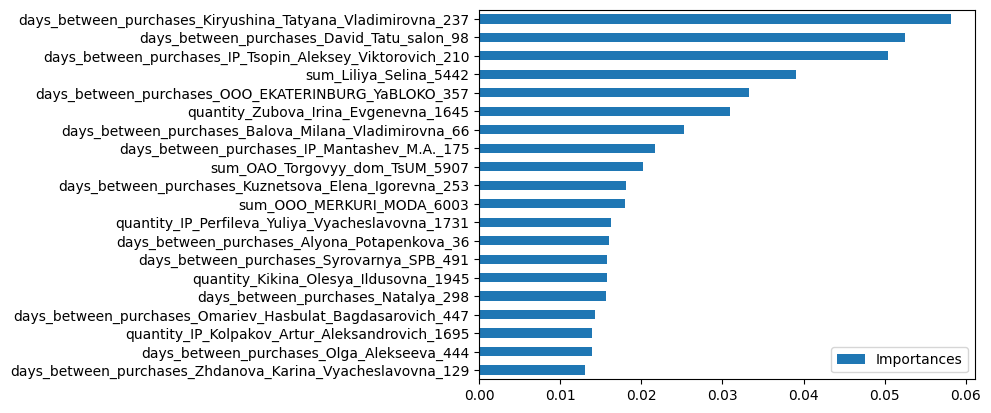

In [13]:
fi = pd.DataFrame(data=xgboost_model.best_cv_model.feature_importances_, index=xgboost_model.best_cv_model.feature_names_in_, columns=['Importances'])
fi.sort_values('Importances', ascending=True)[-20:].plot(kind='barh')

In [14]:
lower_bound, upper_bound = xgboost_model.calculate_low_up_bounds(y_pred, margin_of_error, y_test.index)
xgb_plot = SalesVisualization(y_train=y_train, 
                              y_test=y_test, 
                              y_pred=y_pred, 
                              model_mse=mse, 
                              logs=models_results_logs, 
                              lower_bound=lower_bound, 
                              upper_bound=upper_bound, 
                              margin_of_error=margin_of_error)

In [15]:
xgb_plot.compare_with_dummy_model()

MODEL IS OK


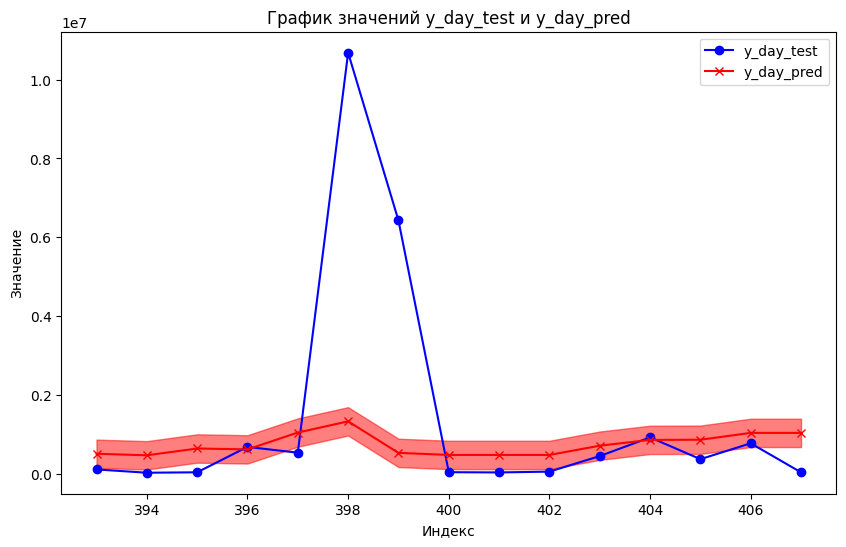

Фактические продажи ниже lower_bound 9, 60.00%
Фактические продажи выше upper_bound 2, 13.33%
Фактические продажи в рамках границ прогнозов 4, 26.67%


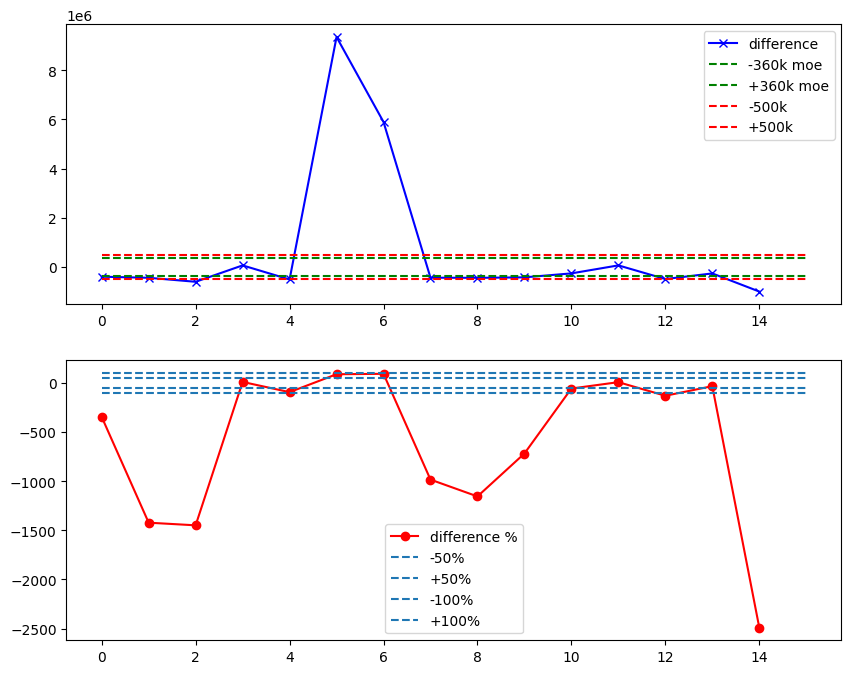

In [16]:
xgb_plot.plot_predictions()
xgb_plot.plot_differences_in_predictions()

In [17]:
xgb_plot.compare_trpred_periods(name=xgboost_model.name, periods=[7, 14, 30, 45])
xgb_plot.count_points_diff(points = [10, 25, 50, 100, 200])

Revenue for last 7 days was 18566149.00
Predicted revenue 5652450.31
Difference: 12913698.69 69.56%
----------------------
Revenue for last 14 days was 21235491.00
Predicted revenue 11145778.44
Difference: 10089712.56 47.51%
----------------------
#####
#####
Total fact sales = 21235491.0
Total pred sales = 11145779.0
Total fact sales minus total pred sales = 10089712.00
Total Accuracy score: 52.49%
Mean accuracy (on each point) -505.43%
----------------------
Всего точек для прогноза 15
В результатах прогноза 13 точек имеют разницу с фактов более 10%
В результатах прогноза 13 точек имеют разницу с фактов более 25%
В результатах прогноза 12 точек имеют разницу с фактов более 50%
В результатах прогноза 8 точек имеют разницу с фактов более 100%
В результатах прогноза 7 точек имеют разницу с фактов более 200%


In [18]:
models_results_logs.all_models_parametrs

,Accuracy,MSE_crossval,MSE_test,best_params,features_vec,mean_accuracy
XGBoost,52.49,3.52E+11,8.34E+12,"{'max_depth': 5, 'learning_rate': 0.2958157538...","['0', '0', '1', '1', '1']",-505.43


LGBM train
----------

In [19]:
lgbm_model = TreeBoostedSalesModel(df=df,
                                      model_strategy=LGBMStrategy(), 
                                      num_features_blocks=FEATURES_BLOCKS_QUANTITY_LGBM,
                                      logs=models_results_logs)

In [20]:
lgbm_model.main_loop_with_cv(chunks=CHUNKS,
                                validation_size=VALIDATION_SIZE,
                                cv_offset_list=CROSVAL_LIST)

Nothing new to merge


In [21]:
lgbm_model.set_results_table()
lgbm_model.models_results.head(10)

Worst MSE 532143689103.6294
Best  MSE 352442844697.8878
Worst time 1.416 seconds
Best  time 0.04 seconds


,set_data_augmentation,set_goods_features,set_agents_features,set_lag_features,set_rolling_average_features,set_onehot_dummy_features,set_multi_dummy_features,MSE,params_num,fit_time
0,0,0,1,0,1,1,0,3.524428e+11,7120,0.690
1,0,0,1,0,1,0,0,3.530500e+11,7113,0.734
2,0,0,1,0,1,1,1,3.630889e+11,10528,0.826
3,0,1,1,1,1,1,1,3.703123e+11,10939,0.962
4,0,1,1,1,1,1,0,3.703123e+11,7531,0.873
5,0,0,1,0,1,0,1,3.745184e+11,10521,0.937
6,0,0,1,0,0,0,1,3.774424e+11,10510,0.953
7,0,0,1,0,0,0,0,3.847132e+11,7102,0.727
8,0,0,1,1,1,1,1,3.853701e+11,10532,0.859
9,0,0,1,1,1,1,0,3.853948e+11,7124,0.677


In [22]:
lgbm_model.select_top_model_vec(top_mse = 3, top_fit_time = 1)
lgbm_model.selected_model_combination

['0', '0', '1', '0', '1', '1', '0']

In [23]:
mse_day, _, _ = lgbm_model._train_tree(data=lgbm_model.selected_data_for_best_model, 
                                          cross_validation=False, 
                                          logs=False, 
                                          validation_size=TEST_SIZE+1, 
                                          params=None)
print(f'MSE default_LGBM day prediction: {mse_day}')

MSE default_LGBM day prediction: 8022380574169.702


In [24]:
best_params = lgbm_model.start_optuna(data=lgbm_model.selected_data_for_best_model, n_trials=OPTUNA_TRIALS_LGBM) 

[I 2024-05-08 05:11:12,834] A new study created in memory with name: no-name-2a9bc278-c6a2-49ed-bf69-76a74a0af817
[I 2024-05-08 05:11:14,152] Trial 0 finished with value: -421574946932.32385 and parameters: {'n_estimators': 801, 'learning_rate': 0.001998764178135828, 'num_leaves': 133, 'max_depth': 7, 'min_child_samples': 46, 'subsample': 0.6354150591123782, 'colsample_bytree': 0.9024176390261894, 'reg_alpha': 1.1446737723377548e-05, 'reg_lambda': 6.222664743747069e-08}. Best is trial 0 with value: -421574946932.32385.
[I 2024-05-08 05:11:15,141] Trial 1 finished with value: -368382775073.67413 and parameters: {'n_estimators': 414, 'learning_rate': 0.01737787351987231, 'num_leaves': 141, 'max_depth': 5, 'min_child_samples': 41, 'subsample': 0.597743051073792, 'colsample_bytree': 0.8488394289186139, 'reg_alpha': 0.0007372193151587555, 'reg_lambda': 4.798512958440173e-06}. Best is trial 1 with value: -368382775073.67413.
[I 2024-05-08 05:11:16,060] Trial 2 finished with value: -413338640

Лучшие параметры: {'n_estimators': 736, 'learning_rate': 0.03630556917678473, 'num_leaves': 18, 'max_depth': 8, 'min_child_samples': 42, 'subsample': 0.8539214168188578, 'colsample_bytree': 0.5827711509062936, 'reg_alpha': 0.0008281688305223492, 'reg_lambda': 0.00018184221041945759}
Лучший результат XGB VAL (MSE): 3.39E+11


In [25]:
_, margin_of_error = lgbm_model._train_tree(data=lgbm_model.selected_data_for_best_model, 
                                               cross_validation=True, 
                                               chunks=CHUNKS, 
                                               validation_size=VALIDATION_SIZE, 
                                               cv_offset_list = CROSVAL_LIST, 
                                               params=best_params)

Test LGMB

In [26]:
# Оценка модели
y_train, y_test, y_pred, mse = lgbm_model.get_best_model_pred_on_test(df=df,
                                                                         test_size=TEST_SIZE+1)

MSE for day prediction with best XGB model: 7411367517380.184


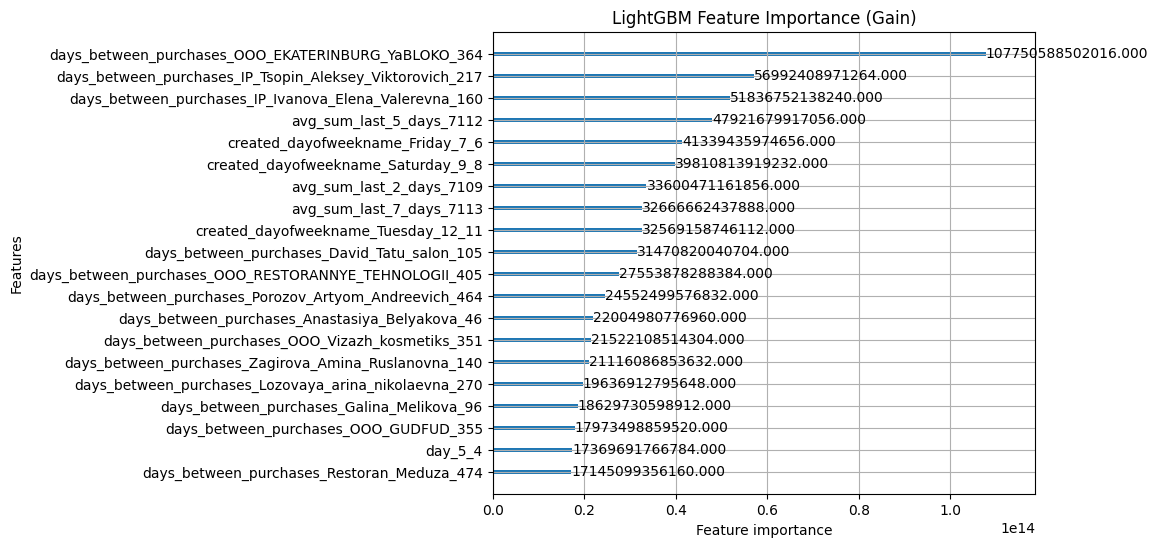

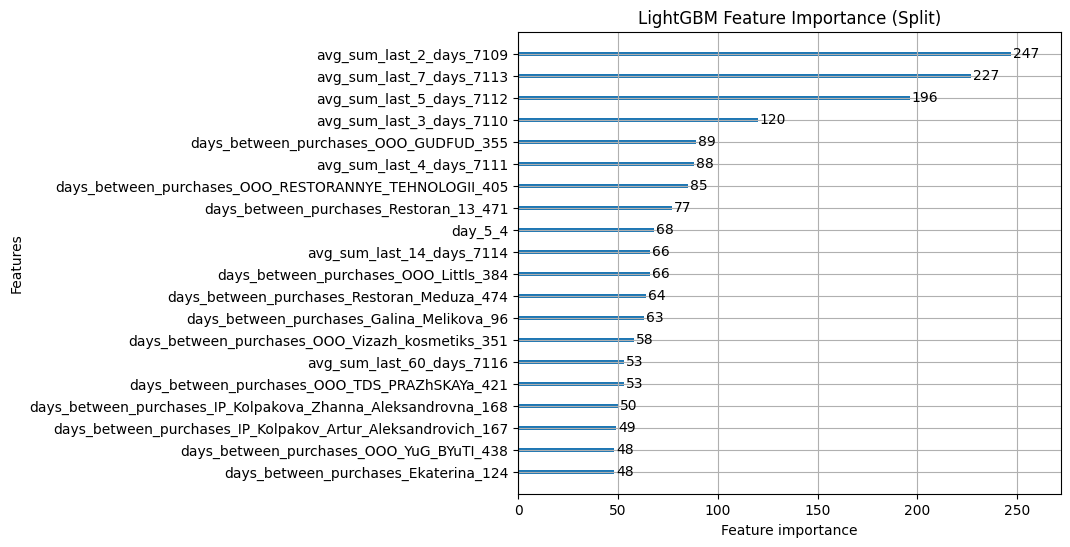

In [27]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

plot_importance(lgbm_model.best_cv_model, importance_type="gain", figsize=(7,6), max_num_features=20, title="LightGBM Feature Importance (Gain)")
plot_importance(lgbm_model.best_cv_model, importance_type="split", figsize=(7,6), max_num_features=20, title="LightGBM Feature Importance (Split)")
plt.show()

In [28]:
lower_bound, upper_bound = lgbm_model.calculate_low_up_bounds(y_pred, margin_of_error, y_test.index)
lgbm_plot = SalesVisualization(y_train=y_train, 
                              y_test=y_test, 
                              y_pred=y_pred, 
                              model_mse=mse, 
                              logs=models_results_logs, 
                              lower_bound=lower_bound, 
                              upper_bound=upper_bound, 
                              margin_of_error=margin_of_error)

In [29]:
lgbm_plot.compare_with_dummy_model()

MODEL IS OK


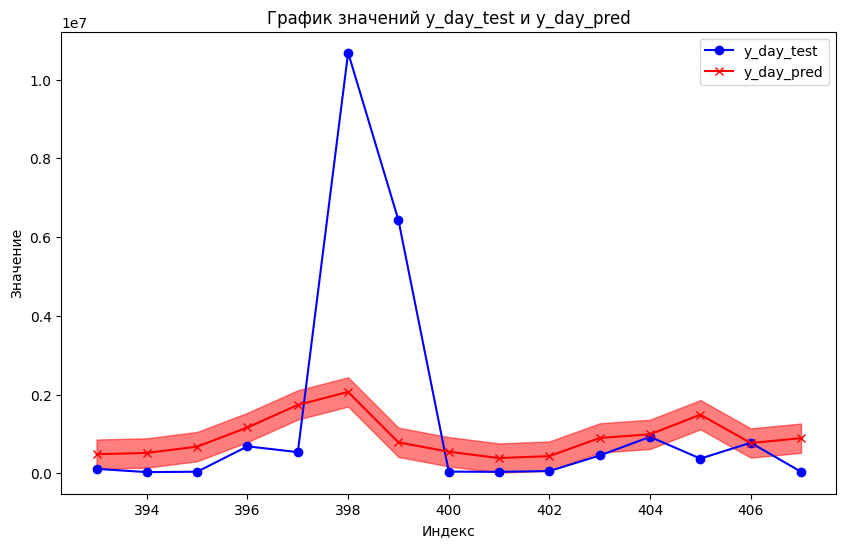

Фактические продажи ниже lower_bound 9, 60.00%
Фактические продажи выше upper_bound 2, 13.33%
Фактические продажи в рамках границ прогнозов 4, 26.67%


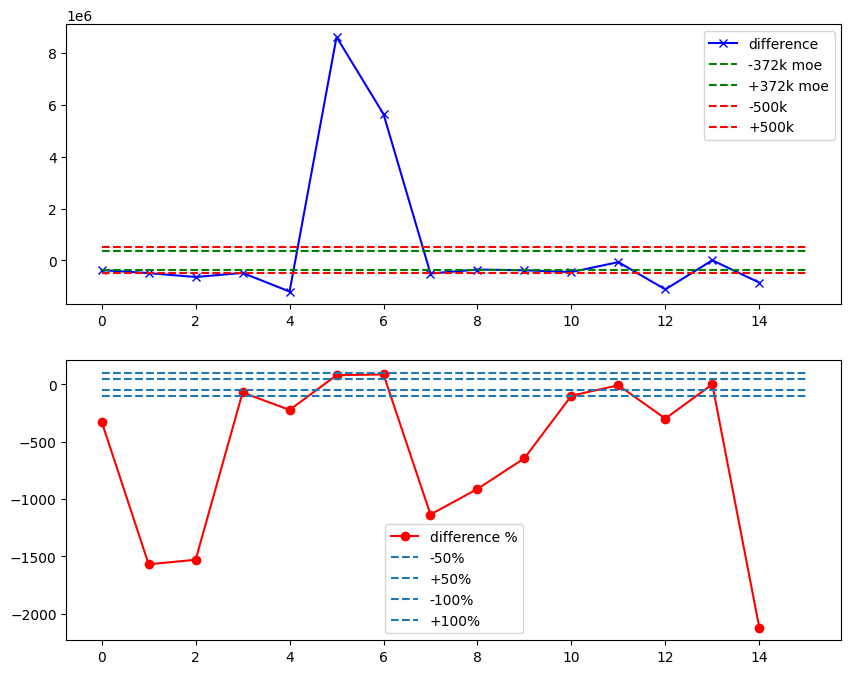

In [30]:
lgbm_plot.plot_predictions()
lgbm_plot.plot_differences_in_predictions()

In [31]:
lgbm_plot.compare_trpred_periods(name=lgbm_model.name, periods=[7, 14, 30, 45])
lgbm_plot.count_points_diff(points = [10, 25, 50, 100, 200])

Revenue for last 7 days was 18566149.00
Predicted revenue 7990973.69
Difference: 10575175.31 56.96%
----------------------
Revenue for last 14 days was 21235491.00
Predicted revenue 13861104.89
Difference: 7374386.11 34.73%
----------------------
#####
#####
Total fact sales = 21235491.0
Total pred sales = 13861104.890076185
Total fact sales minus total pred sales = 7374386.11
Total Accuracy score: 65.27%
Mean accuracy (on each point) -506.90%
----------------------
Всего точек для прогноза 15
В результатах прогноза 13 точек имеют разницу с фактов более 10%
В результатах прогноза 13 точек имеют разницу с фактов более 25%
В результатах прогноза 13 точек имеют разницу с фактов более 50%
В результатах прогноза 9 точек имеют разницу с фактов более 100%
В результатах прогноза 9 точек имеют разницу с фактов более 200%


In [32]:
models_results_logs.all_models_parametrs

,Accuracy,MSE_crossval,MSE_test,best_params,features_vec,mean_accuracy
LGBM,65.27,3.39E+11,7.41E+12,"{'n_estimators': 736, 'learning_rate': 0.03630...","['0', '0', '1', '0', '1', '1', '0']",-506.90
XGBoost,52.49,3.52E+11,8.34E+12,"{'max_depth': 5, 'learning_rate': 0.2958157538...","['0', '0', '1', '1', '1']",-505.43


CatBoost train
--------

In [35]:
catboost_model = TreeBoostedSalesModel(df=df,
                                      model_strategy=CatBoostStrategy(), 
                                      num_features_blocks=FEATURES_BLOCKS_QUANTITY_CATBOOST,
                                      logs=models_results_logs)

In [36]:
catboost_model.main_loop_with_cv(chunks=CHUNKS,
                                validation_size=VALIDATION_SIZE,
                                cv_offset_list=CROSVAL_LIST)

Nothing new to merge


In [37]:
catboost_model.set_results_table()
catboost_model.models_results.head(10)

Worst MSE 553306914773.4951
Best  MSE 410132267036.30725
Worst time 18.953 seconds
Best  time 0.114 seconds


,set_data_augmentation,set_goods_features,set_agents_features,set_lag_features,set_rolling_average_features,MSE,params_num,fit_time
0,1,0,1,1,1,4.101323e+11,8538,18.953
1,1,0,1,0,0,4.138698e+11,8523,16.988
2,0,0,1,1,0,4.249259e+11,7106,15.423
3,0,1,1,0,0,4.282968e+11,7509,13.394
4,1,1,0,0,1,4.526408e+11,424,1.788
5,0,0,1,1,1,4.528178e+11,7117,8.054
6,1,0,1,1,0,4.541254e+11,8527,9.299
7,0,0,1,0,1,4.578533e+11,7113,9.596
8,1,1,0,0,0,4.615738e+11,413,3.660
9,0,1,1,0,1,4.716706e+11,7520,10.320


In [38]:
catboost_model.select_top_model_vec(top_mse = 3, top_fit_time = 1)
catboost_model.selected_model_combination

['0', '0', '1', '1', '0']

In [39]:
mse_day, _, _ = catboost_model._train_tree(data=catboost_model.selected_data_for_best_model, 
                                          cross_validation=False, 
                                          logs=False, 
                                          validation_size=TEST_SIZE+1, 
                                          params=None)
print(f'MSE default_XGBRegressor day prediction: {mse_day}')

MSE default_XGBRegressor day prediction: 8462073520776.947


In [40]:
best_params = catboost_model.start_optuna(data=catboost_model.selected_data_for_best_model, n_trials=OPTUNA_TRIALS_XGBOOST) 

[I 2024-05-08 05:18:26,764] A new study created in memory with name: no-name-cb8eb9ad-a40c-428d-b6d8-c0aae9a881d4
[I 2024-05-08 05:18:33,304] Trial 0 finished with value: -488345833157.9064 and parameters: {'iterations': 518, 'learning_rate': 0.0010103308180927767, 'depth': 2, 'l2_leaf_reg': 0.29612318701544776, 'random_strength': 0.01129776749493198, 'bagging_temperature': 0.17624072805784186, 'border_count': 150}. Best is trial 0 with value: -488345833157.9064.
[I 2024-05-08 05:18:37,594] Trial 1 finished with value: -421169761546.4936 and parameters: {'iterations': 375, 'learning_rate': 0.07622511877284899, 'depth': 3, 'l2_leaf_reg': 4.4964224087726895e-05, 'random_strength': 0.0019554260205959274, 'bagging_temperature': 0.8423767842001463, 'border_count': 178}. Best is trial 1 with value: -421169761546.4936.
[I 2024-05-08 05:18:42,812] Trial 2 finished with value: -418621740504.3705 and parameters: {'iterations': 407, 'learning_rate': 0.013862117336043159, 'depth': 3, 'l2_leaf_reg'

Лучшие параметры: {'iterations': 881, 'learning_rate': 0.006417400178963354, 'depth': 3, 'l2_leaf_reg': 2.849680489189776e-07, 'random_strength': 8.205136911771906e-06, 'bagging_temperature': 0.6116585739517496, 'border_count': 232}
Лучший результат XGB VAL (MSE): 4.06E+11


In [41]:

_, margin_of_error = catboost_model._train_tree(data=catboost_model.selected_data_for_best_model, 
                                               cross_validation=True, 
                                               chunks=CHUNKS, 
                                               validation_size=VALIDATION_SIZE, 
                                               cv_offset_list = CROSVAL_LIST, 
                                               params=best_params)

test

In [42]:
# Оценка модели
y_train, y_test, y_pred, mse = catboost_model.get_best_model_pred_on_test(df=df,
                                                                         test_size=TEST_SIZE+1)                            

MSE for day prediction with best XGB model: 8723688473156.02


<Axes: >

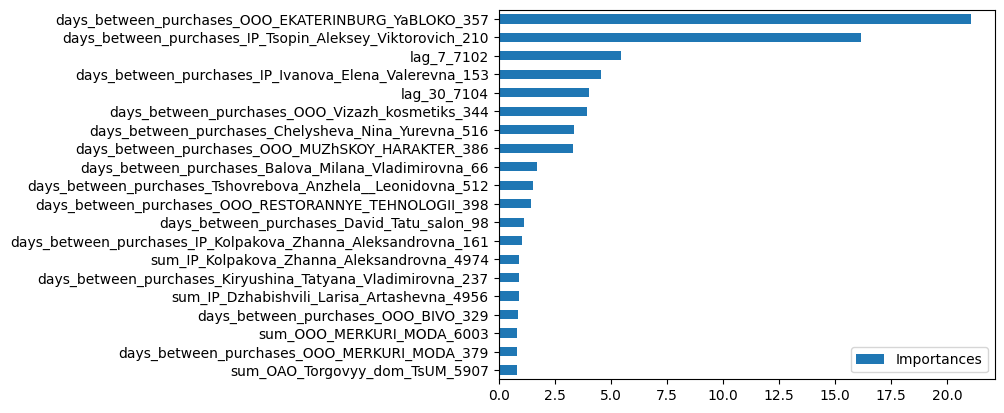

In [43]:
feature_importance = catboost_model.best_cv_model.feature_importances_
feature_names = catboost_model.best_cv_model.feature_names_
fi = pd.DataFrame(data=feature_importance, index=feature_names, columns=['Importances'])
fi.sort_values('Importances', ascending=True)[-20:].plot(kind='barh')

In [44]:
lower_bound, upper_bound = catboost_model.calculate_low_up_bounds(y_pred, margin_of_error, y_test.index)
catboost_plot = SalesVisualization(y_train=y_train, 
                              y_test=y_test, 
                              y_pred=y_pred, 
                              model_mse=mse, 
                              logs=models_results_logs, 
                              lower_bound=lower_bound, 
                              upper_bound=upper_bound, 
                              margin_of_error=margin_of_error)

In [45]:
catboost_plot.compare_with_dummy_model()

MODEL IS OK


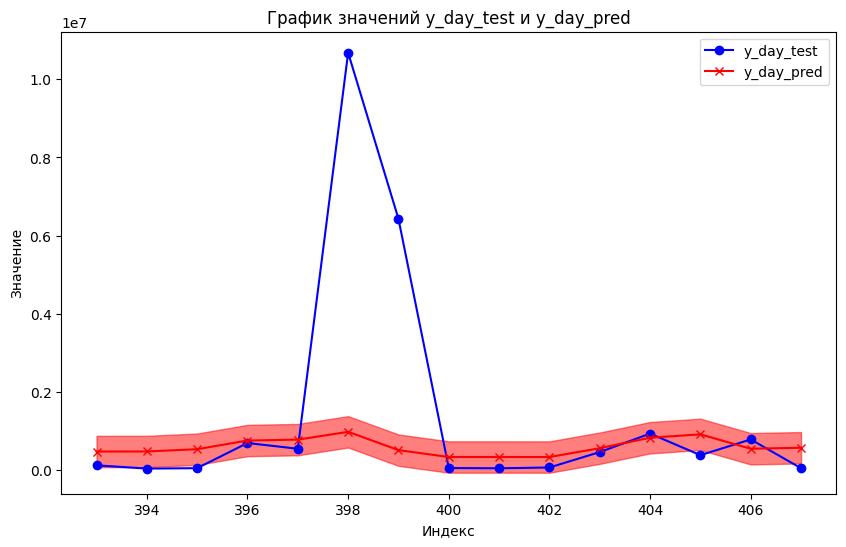

Фактические продажи ниже lower_bound 4, 26.67%
Фактические продажи выше upper_bound 2, 13.33%
Фактические продажи в рамках границ прогнозов 9, 60.00%


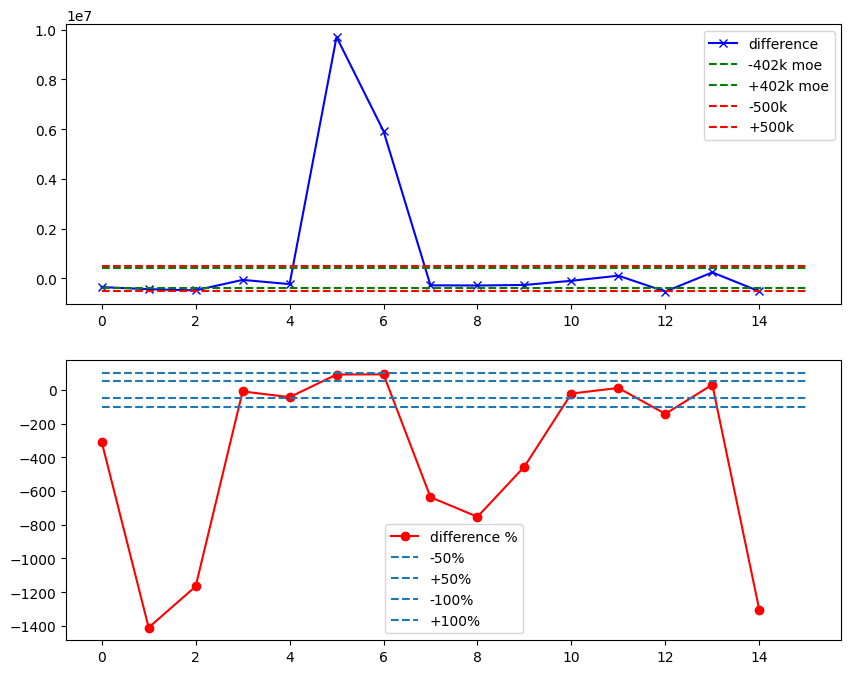

In [46]:
catboost_plot.plot_predictions()
catboost_plot.plot_differences_in_predictions()

In [47]:
catboost_plot.compare_trpred_periods(name=catboost_model.name, periods=[7, 14, 30, 45])
catboost_plot.count_points_diff(points = [10, 25, 50, 100, 200])

Revenue for last 7 days was 18566149.00
Predicted revenue 4788908.18
Difference: 13777240.82 74.21%
----------------------
Revenue for last 14 days was 21235491.00
Predicted revenue 8828721.25
Difference: 12406769.75 58.42%
----------------------
#####
#####
Total fact sales = 21235491.0
Total pred sales = 8828721.249672964
Total fact sales minus total pred sales = 12406769.75
Total Accuracy score: 41.58%
Mean accuracy (on each point) -331.66%
----------------------
Всего точек для прогноза 15
В результатах прогноза 14 точек имеют разницу с фактов более 10%
В результатах прогноза 12 точек имеют разницу с фактов более 25%
В результатах прогноза 10 точек имеют разницу с фактов более 50%
В результатах прогноза 8 точек имеют разницу с фактов более 100%
В результатах прогноза 7 точек имеют разницу с фактов более 200%


In [48]:
models_results_logs.all_models_parametrs

,Accuracy,MSE_crossval,MSE_test,best_params,features_vec,mean_accuracy
CatBoost,41.58,4.06E+11,8.72E+12,"{'iterations': 881, 'learning_rate': 0.0064174...","['0', '0', '1', '1', '0']",-331.66
LGBM,65.27,3.39E+11,7.41E+12,"{'n_estimators': 736, 'learning_rate': 0.03630...","['0', '0', '1', '0', '1', '1', '0']",-506.90
XGBoost,52.49,3.52E+11,8.34E+12,"{'max_depth': 5, 'learning_rate': 0.2958157538...","['0', '0', '1', '1', '1']",-505.43
